In [264]:
#-------------------------------------------------------------
# Import libraries to detect anomalies of simulated heartbeats
#-------------------------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

from gtda.time_series import SlidingWindow
from gtda.time_series import TakensEmbedding

from gtda.homology import VietorisRipsPersistence

import neurokit2 as nk
print('Libraries have been imported')

Libraries have been imported


In [251]:
#---------------------------------------------------------------------
# Simulate 30 seconds of ECG Signal (recorded at 250 samples / second)
#---------------------------------------------------------------------
ecg_signal = nk.ecg_simulate(duration=30, sampling_rate=250)

In [252]:
# ----------------------------------------------------------------------
# Automatically process the (raw) ECG signal
# signals is a dataframe that contains the description of the heartbeats
#  and the column with the hb signal is "ECG_Clean"
# info is a dict with the highest value of the signals
# ------------------------------------------
signals, info = nk.ecg_process(ecg_signal, sampling_rate=250)

In [253]:
# ------------
# Display data
# ------------
print(info)
signals.head(2)

{'ECG_R_Peaks': array([ 213,  430,  647,  862, 1075, 1289, 1502, 1713, 1925, 2139, 2354,
       2569, 2788, 3007, 3222, 3433, 3645, 3859, 4072, 4281, 4492, 4709,
       4929, 5146, 5357, 5572, 5790, 6007, 6216, 6424, 6638, 6857, 7072,
       7283]), 'sampling_rate': 250}


,ECG_Raw,ECG_Clean,ECG_Rate,ECG_Quality,ECG_R_Peaks,ECG_P_Peaks,ECG_P_Onsets,ECG_P_Offsets,ECG_Q_Peaks,ECG_R_Onsets,ECG_R_Offsets,ECG_S_Peaks,ECG_T_Peaks,ECG_T_Onsets,ECG_T_Offsets,ECG_Phase_Atrial,ECG_Phase_Completion_Atrial,ECG_Phase_Ventricular,ECG_Phase_Completion_Ventricular
0,1.093117,-0.070698,70.014144,0.0,0,0,0,0,0,0,0,0,0,0,0,NaN,0.0,NaN,0.0
1,1.039192,-0.196853,70.014144,0.0,0,0,0,0,0,0,0,0,0,0,0,NaN,0.0,NaN,0.0


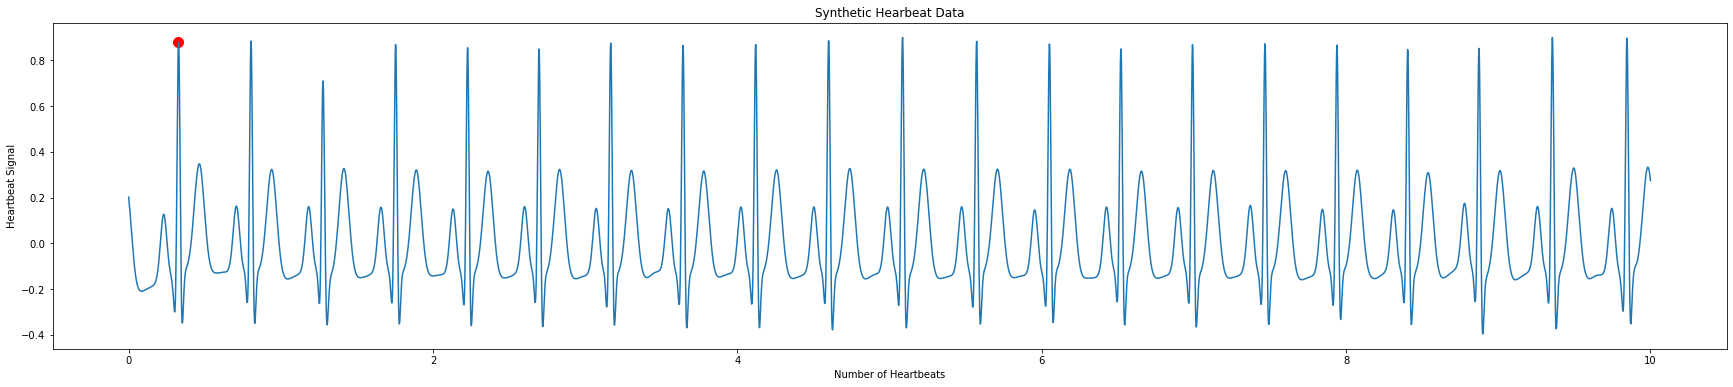

In [254]:
# -----------------------------------------------------------------------------------
# Get part of the heartbeats to compare their signal
# (it seems that simulator generates an incorrect hb at the begginning of the signal)
# -----------------------------------------------------------------------------------
plt.rcParams['figure.figsize'] = [30, 6]    # Set size somehow big to plot various heartbeats
plt.title('Synthetic Hearbeat Data')
plt.ylabel('Heartbeat Signal')
plt.xlabel('Number of Heartbeats')
x_axis = np.linspace(0, 10, 4500)
y_axis = signals["ECG_Clean"][500:5000].values
first_hb_loc = info['ECG_R_Peaks'][2] - 500
plt.plot(x_axis[first_hb_loc], y_axis[first_hb_loc], color='red', marker='o', markersize=10)
_ = plt.plot(x_axis, y_axis)

In [255]:
# ------------------------------------------------------------------------------------------
# Compute the difference between hearbeat peaks to average and define the length of a window
# ------------------------------------------------------------------------------------------
dif_lst = []
for idx in range(len(info['ECG_R_Peaks']) - 1):
    if info['ECG_R_Peaks'][idx] > 499 and info['ECG_R_Peaks'][idx + 1] < 5000:
        #print(info['ECG_R_Peaks'][idx], info['ECG_R_Peaks'][idx + 1], info['ECG_R_Peaks'][idx + 1] - info['ECG_R_Peaks'][idx])
        dif_lst.append(info['ECG_R_Peaks'][idx + 1] - info['ECG_R_Peaks'][idx])
#print(len(dif_lst))
np.average(dif_lst)


214.1

In [256]:
# --------------------------------------------------------
# Set the parameters used during anomaly detection process
# --------------------------------------------------------
window_size = int(np.average(dif_lst))
stride = window_size
time_delay = 1
dimension = 2

nbr_of_jobs = 8
bottom_title = "Number of Hearbeats Compared"

metric_lst = ['landscape', 'betti', 'silhouette', 'wasserstein', 'bottleneck', 'heat']

In [257]:
X = signals["ECG_Clean"][500:5000]
y = signals["ECG_Clean"][500:5000]

In [258]:
# -------------------------------------------------------------------------
# Create sliding windows and size them as the number of measures in one day
# -------------------------------------------------------------------------
SW = SlidingWindow(size=window_size, stride=stride)
X_sw, y_sw = SW.fit_transform_resample(X, y)
print('Time series values:', X_sw.shape, 'Target:', y_sw.shape)

Time series values: (21, 214) Target: (21,)


In [259]:
# ------------------------------------------
# Define the takens embedding of dimension 2
# ------------------------------------------
TE = TakensEmbedding(time_delay=time_delay, dimension=dimension)
X_te = TE.fit_transform(X_sw)
X_te.shape

(21, 213, 2)

In [260]:
#----------------------------------------------------
# Extract topological features of the te data
#----------------------------------------------------
from gtda.homology import VietorisRipsPersistence
VR = VietorisRipsPersistence(homology_dimensions=[0, 1], n_jobs=nbr_of_jobs)  # Parameter explained in the text
diagrams = VR.fit_transform(X_te)
diagrams.shape

(21, 260, 3)

In [261]:
# ------------------------------------
# Display one persistence diagram only
# ------------------------------------
from gtda.plotting import plot_diagram

i = 0
plot_diagram(diagrams[i])

In [262]:
#----------------------------------------------------------
# Compute the distance matrix and store them in a dataframe
#----------------------------------------------------------
from x04_tda_distances import *

dst_mtrx = DistanceMatrix()
pw_dst_lst = []
df_dst_lst = []
for idx in range(0, len(metric_lst)):
    pw_dst, df_dst = dst_mtrx.compute_pw_distance(metric_lst[idx], diagrams)
    pw_dst_lst.append(pw_dst)
    df_dst_lst.append(df_dst)

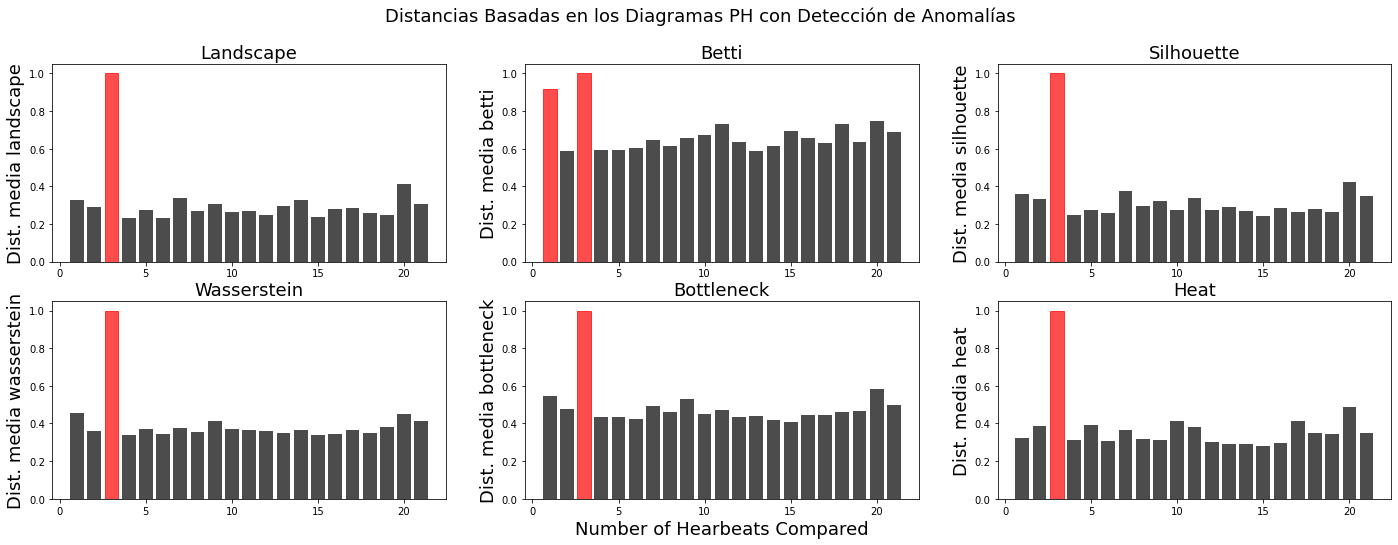

In [263]:
#----------------------------------------------------------
# Plot all distances to check for anomalies in consumption
#----------------------------------------------------------
nbr_of_cols = 3

if int(len(metric_lst) / nbr_of_cols) == len(metric_lst) / nbr_of_cols:
    nbr_of_rows = int(len(metric_lst) / nbr_of_cols)
else:
    nbr_of_rows = int(len(metric_lst) / nbr_of_cols) + 1

fig, axs = plt.subplots(nbr_of_rows, nbr_of_cols, figsize=(24, 8))
fig.suptitle('Distancias Basadas en los Diagramas PH con Detección de Anomalías', fontsize=18)
axs[1, 1].set_xlabel(bottom_title, fontsize=18)

red_lst = []
row = -1
col = 0
for idx in range(0, len(metric_lst)):
    col = idx % nbr_of_cols
    if col == 0: row += 1
    g = df_dst_lst[idx]

    avg_sum = df_dst_lst[idx].sum() / 30
    avg_sum = avg_sum /np.max(avg_sum)

    if idx == 3:
        l_sum = avg_sum

    dst_mean = np.round(np.mean(avg_sum), 2)
    dst_std = np.round(np.std(avg_sum), 2)
    #print(metric_lst[idx], dst_mean, dst_std)

    red_lst.append(np.argwhere(avg_sum.values > (dst_mean + (2*dst_std))))

    axs[row, col].set_title(metric_lst[idx].capitalize(), fontsize=18)
    axs[row, col].set_ylabel('Dist. media ' + metric_lst[idx], fontsize=18)
    #axs[row, col].bar(g.columns, g.sum() / 30, color='black', alpha=.7)
    axs[row, col].bar(g.columns, avg_sum, color='black', alpha=.7)

for idx in range(0, len(red_lst)):
    for red_arg in red_lst[idx]:
        col = idx % 3
        if idx > 2:
            row = 1
        else:
            row = 0
        axs[row, col].get_children()[red_arg[0]].set_color('red')